# 🎯 Advanced Forecasting Models for Loan Sales Prediction

Bu notebook-da aşağıdakı modellər hazırlanır:
- Random Forest Regressor
- XGBoost Regressor
- ARIMA
- SARIMA
- SARIMAX

## Features:
- ✅ Cross-validation
- ✅ Hyperparameter tuning
- ✅ Overfitting prevention
- ✅ Feature importance extraction
- ✅ Model persistence (save/load)
- ✅ Performance metrics

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import pickle
from pathlib import Path
from datetime import datetime

# ML models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Validation and metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Kitabxanalar yükləndi")

✅ Kitabxanalar yükləndi


In [2]:
# Load data
data_path = Path('../data/ml_ready_data.csv')
df = pd.read_csv(data_path)

print(f"📊 Məlumatlar yükləndi: {len(df)} sətir, {len(df.columns)} sütun")
print(f"\nDövr aralığı: {df['Rüblər'].iloc[0]} - {df['Rüblər'].iloc[-1]}")
print(f"\n🎯 Target variable: Nağd_pul_kredit_satışı")
print(f"   Min: {df['Nağd_pul_kredit_satışı'].min():,.2f}")
print(f"   Max: {df['Nağd_pul_kredit_satışı'].max():,.2f}")
print(f"   Ortalama: {df['Nağd_pul_kredit_satışı'].mean():,.2f}")

df.head()

📊 Məlumatlar yükləndi: 22 sətir, 29 sütun

Dövr aralığı: 2020 I - 2025 II

🎯 Target variable: Nağd_pul_kredit_satışı
   Min: 15,709.38
   Max: 126,285.41
   Ortalama: 80,612.82


,Rüblər,Year,Quarter,Time_Index,Nağd_pul_kredit_satışı,GDP,Dövlət_Gəlirləri,Dövlət_Xərcləri,Əhalinin_nominal_gəlirləri,Əhalinin_banklardakı_əmanətləri,...,Mənzil_qiymətləri,Müştərilərə_verilmiş_kreditlər,NPLs,ROA,ROE,Net_Interest_Margin,Efficiency_Ratio,Loan-to-Deposit_Ratio,Müştəri_sayı,Uçot_faiz_dərəcəsi
0,2020 I,2020,1,0,46642.84149,17928100.0,7810900.0,5254800.0,13442500.0,8251700.0,...,1.223936,359233.76244,25.853674,0.461758,2.968748,2.434258,76.900971,130.689125,25304.0,7.25
1,2020 II,2020,2,1,15709.38447,16450600.0,4211800.0,6476000.0,13935300.0,7706400.0,...,1.223569,349405.74088,37.211278,1.425385,7.770286,2.654720,71.419429,131.643899,16316.0,7.00
2,2020 III,2020,3,2,51257.54777,17965600.0,5941800.0,6911300.0,14231200.0,7834300.0,...,1.223447,366496.28305,37.871298,2.184751,11.813249,2.728564,71.328907,135.494827,32598.0,6.50
3,2020 IV,2020,4,3,26391.99772,20233800.0,6708600.0,7775000.0,14117100.0,8177900.0,...,1.223569,337946.33647,26.704039,3.094270,16.588028,2.626730,73.658537,123.697777,28564.0,6.25
4,2021 I,2021,1,4,53293.77411,19181900.0,5736400.0,5523700.0,13455900.0,8147500.0,...,1.247429,355393.13544,39.606834,0.950778,5.080284,2.588275,71.084181,125.430526,39842.0,6.25


## 📐 Feature Engineering

In [3]:
# Create features
df_features = df.copy()

# Time-based features
df_features['Time_Index'] = range(len(df_features))
df_features['Quarter_Sin'] = np.sin(2 * np.pi * df_features['Quarter'] / 4)
df_features['Quarter_Cos'] = np.cos(2 * np.pi * df_features['Quarter'] / 4)

# Lag features (previous periods)
for lag in [1, 2, 3, 4]:
    df_features[f'Lag_{lag}'] = df_features['Nağd_pul_kredit_satışı'].shift(lag)

# Rolling statistics
for window in [2, 3, 4]:
    df_features[f'Rolling_Mean_{window}'] = df_features['Nağd_pul_kredit_satışı'].rolling(window=window).mean()
    df_features[f'Rolling_Std_{window}'] = df_features['Nağd_pul_kredit_satışı'].rolling(window=window).std()

# Trend features
df_features['Diff_1'] = df_features['Nağd_pul_kredit_satışı'].diff()
df_features['Diff_4'] = df_features['Nağd_pul_kredit_satışı'].diff(4)  # Year-over-year

# Drop rows with NaN (due to lag and rolling)
df_features = df_features.dropna()

print(f"✅ Feature Engineering tamamlandı")
print(f"📊 Yeni feature sayı: {len(df_features.columns)}")
print(f"📊 İstifadə ediləcək data: {len(df_features)} sətir")
print(f"\nYaradılan features:")
new_features = [col for col in df_features.columns if col not in df.columns]
for feat in new_features:
    print(f"  - {feat}")

✅ Feature Engineering tamamlandı
📊 Yeni feature sayı: 43
📊 İstifadə ediləcək data: 18 sətir

Yaradılan features:
  - Quarter_Sin
  - Quarter_Cos
  - Lag_1
  - Lag_2
  - Lag_3
  - Lag_4
  - Rolling_Mean_2
  - Rolling_Std_2
  - Rolling_Mean_3
  - Rolling_Std_3
  - Rolling_Mean_4
  - Rolling_Std_4
  - Diff_1
  - Diff_4


## 🔪 Train-Test Split (Time Series)

⚠️ Zaman seriyalarında random split YOXDUR - chronological split olmalıdır!

In [4]:
# Define features for ML models
feature_columns = ['Year', 'Quarter', 'Time_Index', 'Quarter_Sin', 'Quarter_Cos',
                   'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',
                   'Rolling_Mean_2', 'Rolling_Mean_3', 'Rolling_Mean_4',
                   'Rolling_Std_2', 'Rolling_Std_3', 'Rolling_Std_4',
                   'Diff_1', 'Diff_4']

X = df_features[feature_columns]
y = df_features['Nağd_pul_kredit_satışı']

# Time series split - son 20% test
test_size = int(len(X) * 0.2)
train_size = len(X) - test_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"📊 Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"📊 Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n🎯 Train target range: {y_train.min():,.0f} - {y_train.max():,.0f}")
print(f"🎯 Test target range: {y_test.min():,.0f} - {y_test.max():,.0f}")

# Scaling (fit only on train!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Scaling tamamlandı (StandardScaler)")

📊 Train set: 15 samples (83.3%)
📊 Test set: 3 samples (16.7%)

🎯 Train target range: 53,294 - 126,285
🎯 Test target range: 29,174 - 110,883

✅ Scaling tamamlandı (StandardScaler)


## 🌲 Model 1: Random Forest with Cross-Validation

In [5]:
print("🌲 Random Forest - Training başladı...\n")

# Hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Base model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with time series CV
print("🔍 Grid Search başladı (bu bir az vaxt alacaq...)")
rf_grid = GridSearchCV(
    rf_base,
    rf_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit
rf_grid.fit(X_train, y_train)

# Best model
rf_model = rf_grid.best_estimator_

print(f"\n✅ Best parameters tapıldı:")
for param, value in rf_grid.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best CV score: {-rf_grid.best_score_:,.2f} (MAE)")

🌲 Random Forest - Training başladı...

🔍 Grid Search başladı (bu bir az vaxt alacaq...)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✅ Best parameters tapıldı:
   max_depth: 10
   max_features: log2
   min_samples_leaf: 2
   min_samples_split: 2
   n_estimators: 200

📊 Best CV score: 17,445.98 (MAE)


In [6]:
# Random Forest - Predictions and Evaluation
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
rf_metrics = {
    'train': {
        'MAE': mean_absolute_error(y_train, y_train_pred_rf),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_rf)),
        'R2': r2_score(y_train, y_train_pred_rf),
        'MAPE': mean_absolute_percentage_error(y_train, y_train_pred_rf) * 100
    },
    'test': {
        'MAE': mean_absolute_error(y_test, y_test_pred_rf),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
        'R2': r2_score(y_test, y_test_pred_rf),
        'MAPE': mean_absolute_percentage_error(y_test, y_test_pred_rf) * 100
    }
}

print("📊 Random Forest - Performance Metrics:\n")
print("TRAIN SET:")
for metric, value in rf_metrics['train'].items():
    print(f"  {metric}: {value:,.2f}")
print("\nTEST SET:")
for metric, value in rf_metrics['test'].items():
    print(f"  {metric}: {value:,.2f}")

# Overfitting check
r2_diff = rf_metrics['train']['R2'] - rf_metrics['test']['R2']
print(f"\n⚠️ Overfitting check: R² fərqi = {r2_diff:.4f}")
if r2_diff < 0.1:
    print("   ✅ Overfitting YOXDUR")
elif r2_diff < 0.2:
    print("   ⚠️ Yüngül overfitting")
else:
    print("   ❌ Overfitting mövcuddur!")

📊 Random Forest - Performance Metrics:

TRAIN SET:
  MAE: 5,210.56
  RMSE: 7,391.43
  R2: 0.87
  MAPE: 6.41

TEST SET:
  MAE: 25,317.66
  RMSE: 37,005.37
  R2: -0.10
  MAPE: 76.60

⚠️ Overfitting check: R² fərqi = 0.9776
   ❌ Overfitting mövcuddur!


🎯 Random Forest - Top 10 Feature Importance:

       feature  importance
Rolling_Mean_2    0.211084
         Lag_4    0.142028
    Time_Index    0.122442
Rolling_Mean_3    0.098574
Rolling_Mean_4    0.070312
         Lag_2    0.065069
        Diff_1    0.057602
          Year    0.038687
         Lag_3    0.036744
         Lag_1    0.033972


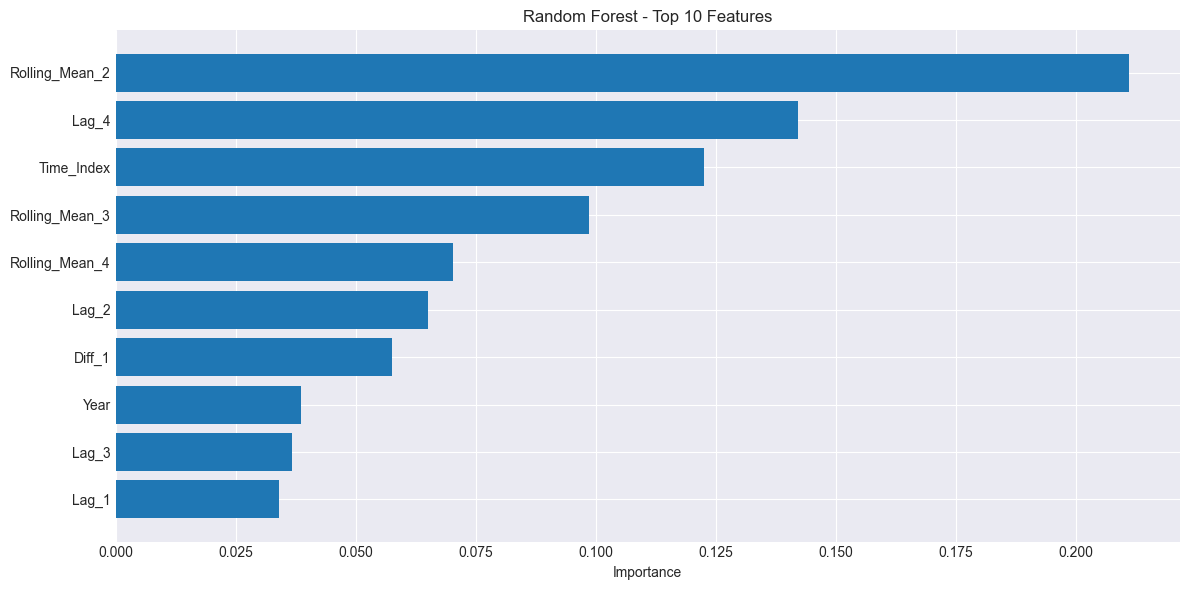


💾 Feature importance chart saved: models/rf_feature_importance.png


In [7]:
# Feature Importance - Random Forest
rf_feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 Random Forest - Top 10 Feature Importance:\n")
print(rf_feature_importance.head(10).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(rf_feature_importance['feature'][:10], rf_feature_importance['importance'][:10])
plt.xlabel('Importance')
plt.title('Random Forest - Top 10 Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('models/rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Feature importance chart saved: models/rf_feature_importance.png")

## 🚀 Model 2: XGBoost with Cross-Validation

In [8]:
print("🚀 XGBoost - Training başladı...\n")

# Hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Base model
xgb_base = XGBRegressor(random_state=42, n_jobs=-1, tree_method='hist')

# Grid search
print("🔍 Grid Search başladı (bu daha uzun çəkəcək...)")
xgb_grid = GridSearchCV(
    xgb_base,
    xgb_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit
xgb_grid.fit(X_train, y_train)

# Best model
xgb_model = xgb_grid.best_estimator_

print(f"\n✅ Best parameters tapıldı:")
for param, value in xgb_grid.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best CV score: {-xgb_grid.best_score_:,.2f} (MAE)")

🚀 XGBoost - Training başladı...

🔍 Grid Search başladı (bu daha uzun çəkəcək...)
Fitting 5 folds for each of 6912 candidates, totalling 34560 fits

✅ Best parameters tapıldı:
   colsample_bytree: 0.9
   gamma: 0
   learning_rate: 0.05
   max_depth: 7
   min_child_weight: 1
   n_estimators: 300
   subsample: 0.7

📊 Best CV score: 14,799.57 (MAE)


In [9]:
# XGBoost - Predictions and Evaluation
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Metrics
xgb_metrics = {
    'train': {
        'MAE': mean_absolute_error(y_train, y_train_pred_xgb),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)),
        'R2': r2_score(y_train, y_train_pred_xgb),
        'MAPE': mean_absolute_percentage_error(y_train, y_train_pred_xgb) * 100
    },
    'test': {
        'MAE': mean_absolute_error(y_test, y_test_pred_xgb),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
        'R2': r2_score(y_test, y_test_pred_xgb),
        'MAPE': mean_absolute_percentage_error(y_test, y_test_pred_xgb) * 100
    }
}

print("📊 XGBoost - Performance Metrics:\n")
print("TRAIN SET:")
for metric, value in xgb_metrics['train'].items():
    print(f"  {metric}: {value:,.2f}")
print("\nTEST SET:")
for metric, value in xgb_metrics['test'].items():
    print(f"  {metric}: {value:,.2f}")

# Overfitting check
r2_diff = xgb_metrics['train']['R2'] - xgb_metrics['test']['R2']
print(f"\n⚠️ Overfitting check: R² fərqi = {r2_diff:.4f}")
if r2_diff < 0.1:
    print("   ✅ Overfitting YOXDUR")
elif r2_diff < 0.2:
    print("   ⚠️ Yüngül overfitting")
else:
    print("   ❌ Overfitting mövcuddur!")

📊 XGBoost - Performance Metrics:

TRAIN SET:
  MAE: 30.29
  RMSE: 52.11
  R2: 1.00
  MAPE: 0.03

TEST SET:
  MAE: 25,970.90
  RMSE: 38,974.24
  R2: -0.22
  MAPE: 79.90

⚠️ Overfitting check: R² fərqi = 1.2247
   ❌ Overfitting mövcuddur!


🎯 XGBoost - Top 10 Feature Importance:

       feature  importance
         Lag_4    0.332863
Rolling_Mean_2    0.262075
    Time_Index    0.116904
         Lag_2    0.058353
   Quarter_Cos    0.038864
   Quarter_Sin    0.035373
          Year    0.031321
 Rolling_Std_3    0.027664
       Quarter    0.026336
 Rolling_Std_4    0.017004


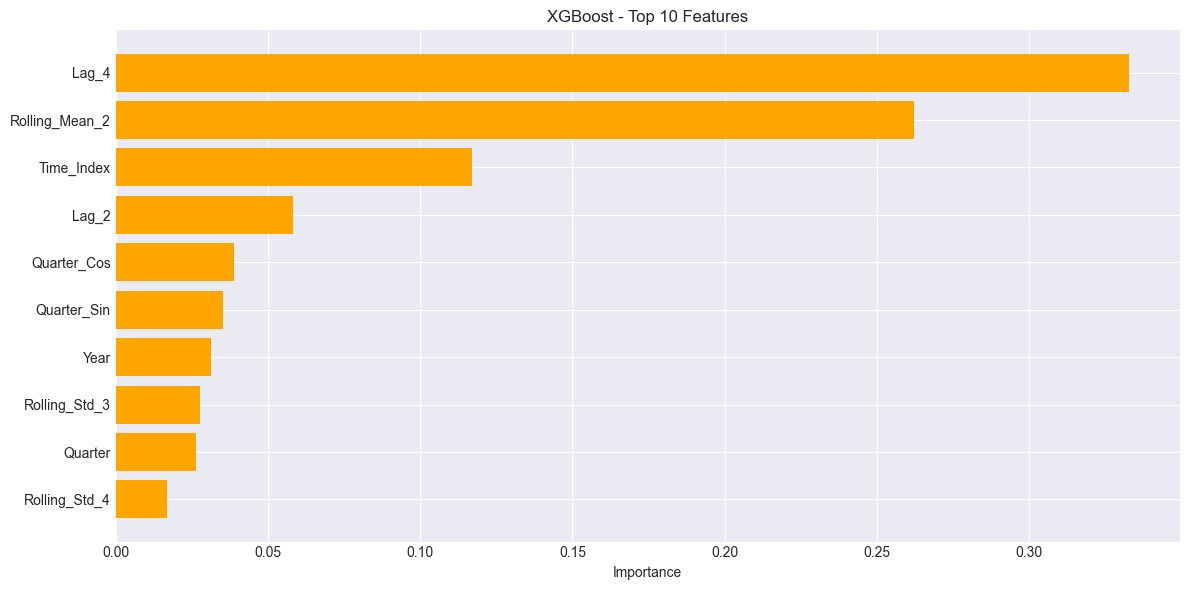


💾 Feature importance chart saved: models/xgb_feature_importance.png


In [10]:
# Feature Importance - XGBoost
xgb_feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 XGBoost - Top 10 Feature Importance:\n")
print(xgb_feature_importance.head(10).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(xgb_feature_importance['feature'][:10], xgb_feature_importance['importance'][:10], color='orange')
plt.xlabel('Importance')
plt.title('XGBoost - Top 10 Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('models/xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Feature importance chart saved: models/xgb_feature_importance.png")

## 📈 Model 3: ARIMA

In [11]:
print("📈 ARIMA - Training başladı...\n")

# For ARIMA, we use only the target variable (univariate)
y_full = df['Nağd_pul_kredit_satışı']
arima_train_size = int(len(y_full) * 0.8)
y_arima_train = y_full[:arima_train_size]
y_arima_test = y_full[arima_train_size:]

# Grid search for best (p, d, q)
best_aic = np.inf
best_order = None
best_arima = None

# Search space
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

print("🔍 Grid Search for ARIMA (p, d, q)...")
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(y_arima_train, order=(p, d, q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p, d, q)
                    best_arima = fitted
            except:
                continue

print(f"\n✅ Best ARIMA order: {best_order}")
print(f"📊 Best AIC: {best_aic:.2f}")

arima_model = best_arima

📈 ARIMA - Training başladı...

🔍 Grid Search for ARIMA (p, d, q)...

✅ Best ARIMA order: (1, 2, 1)
📊 Best AIC: 345.54


In [12]:
# ARIMA - Predictions and Evaluation
y_arima_train_pred = arima_model.fittedvalues
y_arima_test_pred = arima_model.forecast(steps=len(y_arima_test))

# Metrics
arima_metrics = {
    'train': {
        'MAE': mean_absolute_error(y_arima_train[best_order[1]:], y_arima_train_pred[best_order[1]:]),
        'RMSE': np.sqrt(mean_squared_error(y_arima_train[best_order[1]:], y_arima_train_pred[best_order[1]:])),
        'R2': r2_score(y_arima_train[best_order[1]:], y_arima_train_pred[best_order[1]:]),
        'MAPE': mean_absolute_percentage_error(y_arima_train[best_order[1]:], y_arima_train_pred[best_order[1]:]) * 100
    },
    'test': {
        'MAE': mean_absolute_error(y_arima_test, y_arima_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_arima_test, y_arima_test_pred)),
        'R2': r2_score(y_arima_test, y_arima_test_pred),
        'MAPE': mean_absolute_percentage_error(y_arima_test, y_arima_test_pred) * 100
    }
}

print("📊 ARIMA - Performance Metrics:\n")
print("TRAIN SET:")
for metric, value in arima_metrics['train'].items():
    print(f"  {metric}: {value:,.2f}")
print("\nTEST SET:")
for metric, value in arima_metrics['test'].items():
    print(f"  {metric}: {value:,.2f}")

📊 ARIMA - Performance Metrics:

TRAIN SET:
  MAE: 14,508.01
  RMSE: 19,389.85
  R2: 0.40
  MAPE: 21.86

TEST SET:
  MAE: 27,847.51
  RMSE: 36,124.14
  R2: -0.09
  MAPE: 60.06


## 🌊 Model 4: SARIMA (Seasonal ARIMA)

In [13]:
print("🌊 SARIMA - Training başladı...\n")

# SARIMA with seasonal component (m=4 for quarterly data)
best_aic_sarima = np.inf
best_order_sarima = None
best_seasonal_order = None
best_sarima = None

# Reduced search space for faster execution
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
m = 4  # Quarterly seasonality

print("🔍 Grid Search for SARIMA (p, d, q) × (P, D, Q, m)...")
print("   (Bu uzun çəkə bilər...)\n")

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            model = SARIMAX(
                                y_arima_train,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, m),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            fitted = model.fit(disp=False)
                            if fitted.aic < best_aic_sarima:
                                best_aic_sarima = fitted.aic
                                best_order_sarima = (p, d, q)
                                best_seasonal_order = (P, D, Q, m)
                                best_sarima = fitted
                        except:
                            continue

print(f"\n✅ Best SARIMA order: {best_order_sarima}")
print(f"✅ Best seasonal order: {best_seasonal_order}")
print(f"📊 Best AIC: {best_aic_sarima:.2f}")

sarima_model = best_sarima

🌊 SARIMA - Training başladı...

🔍 Grid Search for SARIMA (p, d, q) × (P, D, Q, m)...
   (Bu uzun çəkə bilər...)


✅ Best SARIMA order: (0, 1, 2)
✅ Best seasonal order: (0, 1, 2, 4)
📊 Best AIC: 32.17


In [14]:
# SARIMA - Predictions and Evaluation
y_sarima_train_pred = sarima_model.fittedvalues
y_sarima_test_pred = sarima_model.forecast(steps=len(y_arima_test))

# Metrics
sarima_metrics = {
    'train': {
        'MAE': mean_absolute_error(y_arima_train, y_sarima_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_arima_train, y_sarima_train_pred)),
        'R2': r2_score(y_arima_train, y_sarima_train_pred),
        'MAPE': mean_absolute_percentage_error(y_arima_train, y_sarima_train_pred) * 100
    },
    'test': {
        'MAE': mean_absolute_error(y_arima_test, y_sarima_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_arima_test, y_sarima_test_pred)),
        'R2': r2_score(y_arima_test, y_sarima_test_pred),
        'MAPE': mean_absolute_percentage_error(y_arima_test, y_sarima_test_pred) * 100
    }
}

print("📊 SARIMA - Performance Metrics:\n")
print("TRAIN SET:")
for metric, value in sarima_metrics['train'].items():
    print(f"  {metric}: {value:,.2f}")
print("\nTEST SET:")
for metric, value in sarima_metrics['test'].items():
    print(f"  {metric}: {value:,.2f}")

📊 SARIMA - Performance Metrics:

TRAIN SET:
  MAE: 20,401.90
  RMSE: 24,138.43
  R2: 0.31
  MAPE: 37.58

TEST SET:
  MAE: 23,472.23
  RMSE: 41,719.96
  R2: -0.46
  MAPE: 67.47


## 🎯 Model 5: SARIMAX (with Exogenous Variables)

In [15]:
print("🎯 SARIMAX - Training başladı...\n")

# Prepare exogenous variables
exog_cols = ['Year', 'Quarter']
exog_train = df[exog_cols][:arima_train_size]
exog_test = df[exog_cols][arima_train_size:]

# Use best SARIMA parameters but add exogenous variables
print(f"🔧 Using best SARIMA parameters: {best_order_sarima} × {best_seasonal_order}")
print(f"📊 Adding exogenous variables: {exog_cols}\n")

sarimax_model = SARIMAX(
    y_arima_train,
    exog=exog_train,
    order=best_order_sarima,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(f"✅ SARIMAX model trained")
print(f"📊 AIC: {sarimax_model.aic:.2f}")

🎯 SARIMAX - Training başladı...

🔧 Using best SARIMA parameters: (0, 1, 2) × (0, 1, 2, 4)
📊 Adding exogenous variables: ['Year', 'Quarter']

✅ SARIMAX model trained
📊 AIC: 36.17


In [16]:
# SARIMAX - Predictions and Evaluation
y_sarimax_train_pred = sarimax_model.fittedvalues
y_sarimax_test_pred = sarimax_model.forecast(steps=len(y_arima_test), exog=exog_test)

# Metrics
sarimax_metrics = {
    'train': {
        'MAE': mean_absolute_error(y_arima_train, y_sarimax_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_arima_train, y_sarimax_train_pred)),
        'R2': r2_score(y_arima_train, y_sarimax_train_pred),
        'MAPE': mean_absolute_percentage_error(y_arima_train, y_sarimax_train_pred) * 100
    },
    'test': {
        'MAE': mean_absolute_error(y_arima_test, y_sarimax_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_arima_test, y_sarimax_test_pred)),
        'R2': r2_score(y_arima_test, y_sarimax_test_pred),
        'MAPE': mean_absolute_percentage_error(y_arima_test, y_sarimax_test_pred) * 100
    }
}

print("📊 SARIMAX - Performance Metrics:\n")
print("TRAIN SET:")
for metric, value in sarimax_metrics['train'].items():
    print(f"  {metric}: {value:,.2f}")
print("\nTEST SET:")
for metric, value in sarimax_metrics['test'].items():
    print(f"  {metric}: {value:,.2f}")

📊 SARIMAX - Performance Metrics:

TRAIN SET:
  MAE: 20,334.75
  RMSE: 24,091.95
  R2: 0.32
  MAPE: 37.55

TEST SET:
  MAE: 23,663.05
  RMSE: 42,060.79
  R2: -0.48
  MAPE: 68.06


## 📊 Model Comparison

In [17]:
# Comparison table
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'ARIMA', 'SARIMA', 'SARIMAX'],
    'Test_MAE': [
        rf_metrics['test']['MAE'],
        xgb_metrics['test']['MAE'],
        arima_metrics['test']['MAE'],
        sarima_metrics['test']['MAE'],
        sarimax_metrics['test']['MAE']
    ],
    'Test_RMSE': [
        rf_metrics['test']['RMSE'],
        xgb_metrics['test']['RMSE'],
        arima_metrics['test']['RMSE'],
        sarima_metrics['test']['RMSE'],
        sarimax_metrics['test']['RMSE']
    ],
    'Test_R2': [
        rf_metrics['test']['R2'],
        xgb_metrics['test']['R2'],
        arima_metrics['test']['R2'],
        sarima_metrics['test']['R2'],
        sarimax_metrics['test']['R2']
    ],
    'Test_MAPE': [
        rf_metrics['test']['MAPE'],
        xgb_metrics['test']['MAPE'],
        arima_metrics['test']['MAPE'],
        sarima_metrics['test']['MAPE'],
        sarimax_metrics['test']['MAPE']
    ]
}).sort_values('Test_MAE')

print("\n" + "="*80)
print("🏆 MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*80 + "\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)
print(f"🥇 Best Model (lowest MAE): {comparison_df.iloc[0]['Model']}")
print(f"📊 Best MAE: {comparison_df.iloc[0]['Test_MAE']:,.2f}")
print(f"📊 Best R²: {comparison_df.iloc[0]['Test_R2']:.4f}")
print("="*80)


🏆 MODEL COMPARISON - TEST SET PERFORMANCE

        Model     Test_MAE    Test_RMSE   Test_R2  Test_MAPE
       SARIMA 23472.231489 41719.964705 -0.455636  67.474379
      SARIMAX 23663.050752 42060.789100 -0.479516  68.063005
Random Forest 25317.662448 37005.372152 -0.104133  76.604696
      XGBoost 25970.895660 38974.240922 -0.224749  79.902196
        ARIMA 27847.512136 36124.144081 -0.091340  60.064834

🥇 Best Model (lowest MAE): SARIMA
📊 Best MAE: 23,472.23
📊 Best R²: -0.4556


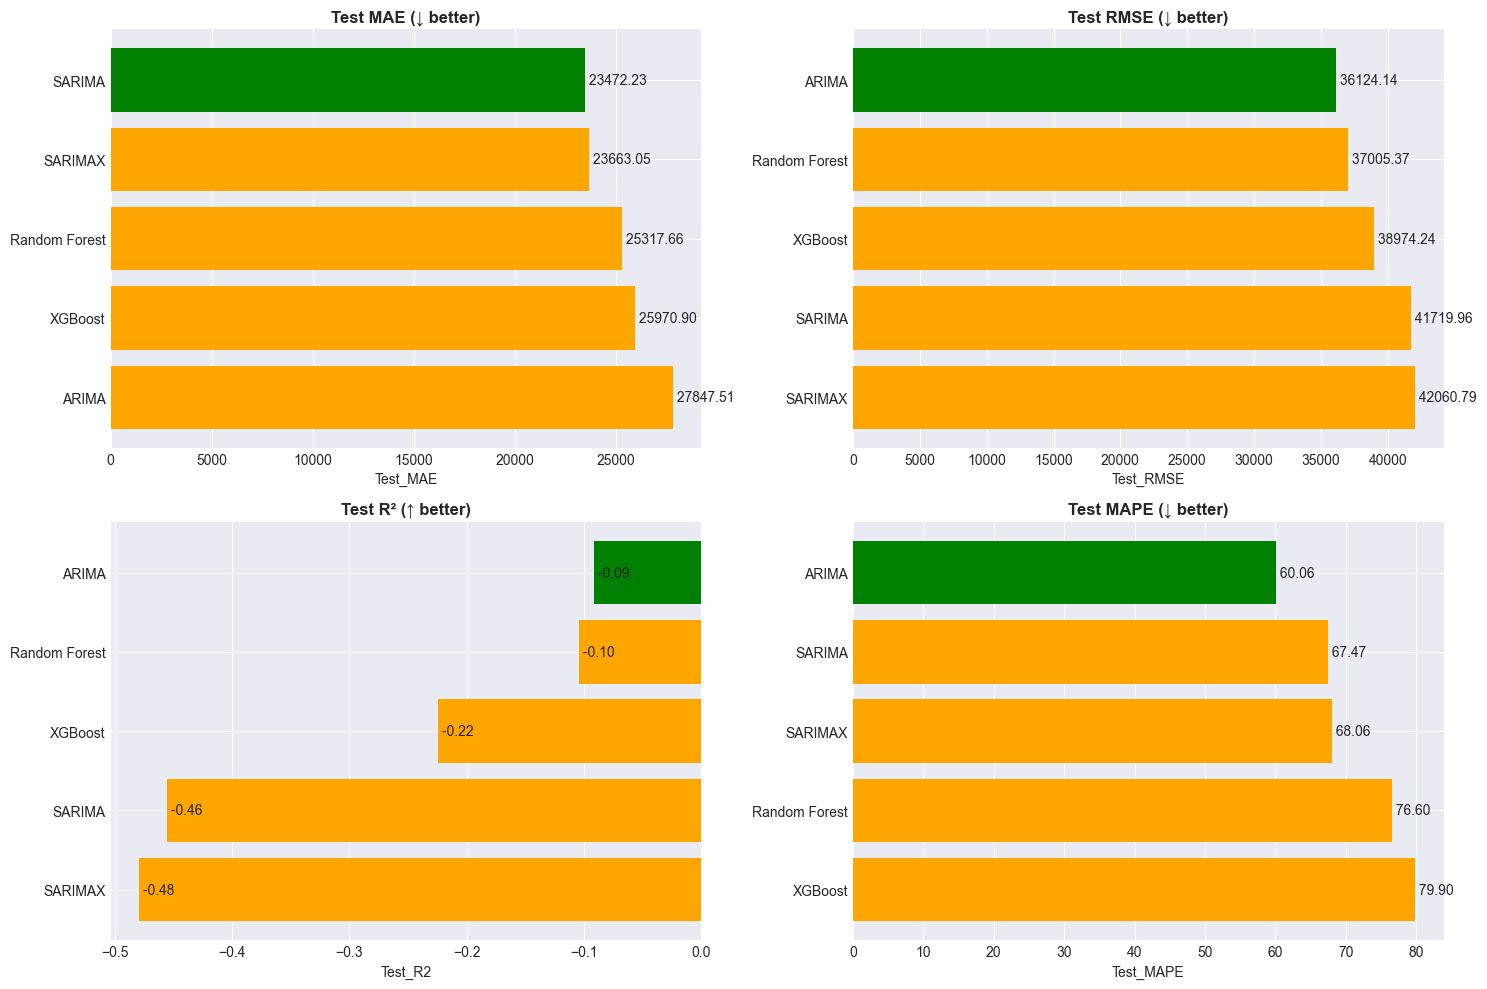


💾 Comparison chart saved: models/model_comparison.png


In [18]:
# Visualization - Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Test_MAE', 'Test_RMSE', 'Test_R2', 'Test_MAPE']
titles = ['Test MAE (↓ better)', 'Test RMSE (↓ better)', 'Test R² (↑ better)', 'Test MAPE (↓ better)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    sorted_df = comparison_df.sort_values(metric, ascending=(metric != 'Test_R2'))
    colors = ['green' if i == 0 else 'orange' for i in range(len(sorted_df))]
    ax.barh(sorted_df['Model'], sorted_df[metric], color=colors)
    ax.set_xlabel(metric)
    ax.set_title(title, fontweight='bold')
    ax.invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v, i, f' {v:.2f}', va='center')

plt.tight_layout()
plt.savefig('models/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Comparison chart saved: models/model_comparison.png")

## 💾 Save All Models

In [19]:
print("💾 Modelləri saxlayır...\n")

models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

# Save ML models (Random Forest, XGBoost)
with open(models_dir / 'random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✅ Random Forest saved: models/random_forest.pkl")

with open(models_dir / 'xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("✅ XGBoost saved: models/xgboost.pkl")

# Save scaler
with open(models_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved: models/scaler.pkl")

# Save time series models (ARIMA, SARIMA, SARIMAX)
arima_model.save(models_dir / 'arima.pkl')
print("✅ ARIMA saved: models/arima.pkl")

sarima_model.save(models_dir / 'sarima.pkl')
print("✅ SARIMA saved: models/sarima.pkl")

sarimax_model.save(models_dir / 'sarimax.pkl')
print("✅ SARIMAX saved: models/sarimax.pkl")

# Save feature importance
rf_feature_importance.to_csv(models_dir / 'rf_feature_importance.csv', index=False)
print("✅ RF Feature Importance saved: models/rf_feature_importance.csv")

xgb_feature_importance.to_csv(models_dir / 'xgb_feature_importance.csv', index=False)
print("✅ XGB Feature Importance saved: models/xgb_feature_importance.csv")

# Save metrics
all_metrics = {
    'random_forest': rf_metrics,
    'xgboost': xgb_metrics,
    'arima': arima_metrics,
    'sarima': sarima_metrics,
    'sarimax': sarimax_metrics,
    'comparison': comparison_df.to_dict('records'),
    'best_model': comparison_df.iloc[0]['Model'],
    'feature_columns': feature_columns,
    'arima_order': best_order,
    'sarima_order': best_order_sarima,
    'sarima_seasonal_order': best_seasonal_order,
    'exog_columns': exog_cols,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(models_dir / 'model_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(all_metrics, f, indent=2, ensure_ascii=False)
print("✅ Metrics saved: models/model_metrics.json")

# Save model info for frontend
model_info = {
    'models': [
        {
            'id': 'random_forest',
            'name': 'Random Forest',
            'type': 'ML',
            'description': 'Ensemble öyrənmə metodu - çoxlu decision tree-lərin ortalaması',
            'test_mae': float(rf_metrics['test']['MAE']),
            'test_r2': float(rf_metrics['test']['R2']),
            'test_mape': float(rf_metrics['test']['MAPE']),
            'best_params': rf_grid.best_params_
        },
        {
            'id': 'xgboost',
            'name': 'XGBoost',
            'type': 'ML',
            'description': 'Gradient boosting - ardıcıl ağaclarla xətaları azaldır',
            'test_mae': float(xgb_metrics['test']['MAE']),
            'test_r2': float(xgb_metrics['test']['R2']),
            'test_mape': float(xgb_metrics['test']['MAPE']),
            'best_params': xgb_grid.best_params_
        },
        {
            'id': 'arima',
            'name': 'ARIMA',
            'type': 'Time Series',
            'description': 'AutoRegressive Integrated Moving Average - klassik zaman seriyası',
            'test_mae': float(arima_metrics['test']['MAE']),
            'test_r2': float(arima_metrics['test']['R2']),
            'test_mape': float(arima_metrics['test']['MAPE']),
            'order': best_order
        },
        {
            'id': 'sarima',
            'name': 'SARIMA',
            'type': 'Time Series',
            'description': 'Seasonal ARIMA - mövsümilik nümunələrini tutmaq üçün',
            'test_mae': float(sarima_metrics['test']['MAE']),
            'test_r2': float(sarima_metrics['test']['R2']),
            'test_mape': float(sarima_metrics['test']['MAPE']),
            'order': best_order_sarima,
            'seasonal_order': best_seasonal_order
        },
        {
            'id': 'sarimax',
            'name': 'SARIMAX',
            'type': 'Time Series',
            'description': 'SARIMA + Exogenous variables - əlavə xarici dəyişənlərlə',
            'test_mae': float(sarimax_metrics['test']['MAE']),
            'test_r2': float(sarimax_metrics['test']['R2']),
            'test_mape': float(sarimax_metrics['test']['MAPE']),
            'order': best_order_sarima,
            'seasonal_order': best_seasonal_order,
            'exog_vars': exog_cols
        }
    ],
    'best_model': comparison_df.iloc[0]['Model'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(models_dir / 'model_info.json', 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=2, ensure_ascii=False)
print("✅ Model info for frontend saved: models/model_info.json")

print("\n" + "="*80)
print("🎉 Bütün modellər uğurla saxlanıldı!")
print("="*80)
print("\n📁 Saved files:")
for file in sorted(models_dir.glob('*')):
    print(f"   {file.name}")

💾 Modelləri saxlayır...

✅ Random Forest saved: models/random_forest.pkl
✅ XGBoost saved: models/xgboost.pkl
✅ Scaler saved: models/scaler.pkl
✅ ARIMA saved: models/arima.pkl
✅ SARIMA saved: models/sarima.pkl
✅ SARIMAX saved: models/sarimax.pkl
✅ RF Feature Importance saved: models/rf_feature_importance.csv
✅ XGB Feature Importance saved: models/xgb_feature_importance.csv
✅ Metrics saved: models/model_metrics.json
✅ Model info for frontend saved: models/model_info.json

🎉 Bütün modellər uğurla saxlanıldı!

📁 Saved files:
   arima.pkl
   model_comparison.png
   model_info.json
   model_metrics.json
   random_forest.pkl
   rf_feature_importance.csv
   rf_feature_importance.png
   sarima.pkl
   sarimax.pkl
   sarimax_production_v1.0.0_20251102_234406.pkl
   sarimax_production_v1.0.0_20251102_234406_metadata.json
   sarimax_production_v1.0.0_20251102_234406_usage.md
   scaler.pkl
   xgb_feature_importance.csv
   xgb_feature_importance.png
   xgboost.pkl


## 🎯 Sample Predictions (Next 4 Quarters)

In [20]:
print("🔮 Növbəti 4 rüb üçün proqnozlar:\n")

n_forecast = 4

# Prepare features for next 4 quarters
last_year = df['Year'].iloc[-1]
last_quarter = df['Quarter'].iloc[-1]
last_time_index = df_features['Time_Index'].iloc[-1]

future_quarters = []
for i in range(1, n_forecast + 1):
    q = ((last_quarter + i - 1) % 4) + 1
    y = last_year + (last_quarter + i - 1) // 4
    future_quarters.append({'Year': y, 'Quarter': q, 'Time_Index': last_time_index + i})

future_df = pd.DataFrame(future_quarters)
future_df['Quarter_Sin'] = np.sin(2 * np.pi * future_df['Quarter'] / 4)
future_df['Quarter_Cos'] = np.cos(2 * np.pi * future_df['Quarter'] / 4)

# For lag features, we need to use recursive forecasting
# Simplified version - use last known values
last_values = df['Nağd_pul_kredit_satışı'].iloc[-4:].values
for i in range(1, 5):
    future_df[f'Lag_{i}'] = last_values[-i] if i <= len(last_values) else last_values[0]

for window in [2, 3, 4]:
    future_df[f'Rolling_Mean_{window}'] = last_values[-window:].mean()
    future_df[f'Rolling_Std_{window}'] = last_values[-window:].std()

future_df['Diff_1'] = 0  # Placeholder
future_df['Diff_4'] = 0  # Placeholder

# Ensure correct column order
future_df = future_df[feature_columns]

# Scale
future_scaled = scaler.transform(future_df)

# Predictions
rf_forecast = rf_model.predict(future_scaled)
xgb_forecast = xgb_model.predict(future_scaled)
arima_forecast = arima_model.forecast(steps=n_forecast)
sarima_forecast = sarima_model.forecast(steps=n_forecast)

# For SARIMAX, need exogenous variables
future_exog = future_df[['Year', 'Quarter']]
sarimax_forecast = sarimax_model.forecast(steps=n_forecast, exog=future_exog)

# Display
forecast_df = pd.DataFrame({
    'Dövr': [f"{row['Year']}-Q{row['Quarter']}" for _, row in future_df.iterrows()],
    'Random_Forest': rf_forecast,
    'XGBoost': xgb_forecast,
    'ARIMA': arima_forecast,
    'SARIMA': sarima_forecast,
    'SARIMAX': sarimax_forecast
})

print(forecast_df.to_string(index=False))
print("\n" + "="*80)

# Save forecasts
forecast_df.to_csv(models_dir / 'sample_forecasts.csv', index=False)
print("\n💾 Forecasts saved: models/sample_forecasts.csv")

🔮 Növbəti 4 rüb üçün proqnozlar:

       Dövr  Random_Forest      XGBoost        ARIMA        SARIMA       SARIMAX
2025.0-Q3.0   71537.337398 63572.753906 95275.206499 111386.316902 111790.326737
2025.0-Q4.0   71566.411063 63575.589844 95534.342022 115263.020335 115734.801430
2026.0-Q1.0   71149.113628 62817.878906 97304.604535 119796.693282 120440.634797
2026.0-Q2.0   71537.337398 64732.812500 98305.041473  95346.571839  95760.671653


💾 Forecasts saved: models/sample_forecasts.csv


## ✅ Summary

### Models Trained:
1. ✅ Random Forest with GridSearchCV
2. ✅ XGBoost with GridSearchCV
3. ✅ ARIMA
4. ✅ SARIMA (seasonal)
5. ✅ SARIMAX (with exogenous variables)

### Validation Techniques:
- ✅ Time Series Cross-Validation (TimeSeriesSplit)
- ✅ Grid Search for hyperparameter tuning
- ✅ Proper train-test split (chronological)
- ✅ Overfitting checks (train vs test metrics)

### Saved Artifacts:
- ✅ All 5 trained models (.pkl files)
- ✅ Scaler for feature normalization
- ✅ Feature importance (CSV + PNG)
- ✅ Model comparison chart
- ✅ Performance metrics (JSON)
- ✅ Model info for frontend (JSON)
- ✅ Sample forecasts

### Next Steps:
1. Backend API-də prediction endpoint yaradın
2. Frontend-də model seçimi dropdown əlavə edin
3. Feature importance visualizasiyası əlavə edin
4. Real-time prediction göstərin